## Import

In [1]:
import pandas as pd
import numpy as np

from scipy.special import digamma
from scipy.spatial.distance import chebyshev

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import mutual_info_regression

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

## Utility Functions

In [2]:
def gaussian_mi(cov):
    """
    Exact MI for multivariate gaussian given the covariance matrix
    """
    return - 1 / 2 * np.log(np.linalg.det(cov))

In [3]:
def generate_data(r=0.3, n=1000, seed=0):
    """
    Generate two-dimensional Gaussian with zero mean, unit variance, and
    correlation r
    """
    rng = np.random.RandomState(seed)
    
    data = rng.multivariate_normal([0, 0], [[1, r], [r, 1]], n)
    
    x = data[:, 0]
    y = data[:, 1]
    
    return x, y

In [4]:
def compare_mi_calc(r=0.3, n=1000, seed=0, k=3):
    x, y = generate_data(r, n, seed)
    
    return {'r': r, 'n': n,
            'exact': gaussian_mi(np.cov(x, y)),
            'eq8': mi_eq8(x, y, k=k), 'eq9': mi_eq9(x, y, k=k),
            'sklearn': mutual_info_regression(x[:, None], y, 
                                              random_state=seed, n_neighbors=k)[0]}

In [5]:
def plot_single_point(x, y, data, i):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.axvline(x[i] + data['x_dist'][i], c='k', ls='--', alpha=0.5)
    ax.axvline(x[i] - data['x_dist'][i], c='k', ls='--', alpha=0.5)
    ax.axhline(y[i] + data['y_dist'][i], c='k', ls='--', alpha=0.5)
    ax.axhline(y[i] - data['y_dist'][i], c='k', ls='--', alpha=0.5)
    ax.scatter(x, y, c='gray', alpha=0.5)
    for neighbor_i in data['x_ind'][i]:
        ax.scatter(x[neighbor_i], y[neighbor_i], c='hotpink')
    for neighbor_i in data['y_ind'][i]:
        ax.scatter(x[neighbor_i], y[neighbor_i], c='purple')
    ax.scatter(x[i], y[i], c='r')
    for neighbor_i in data['ind'][i]:
        ax.scatter(x[neighbor_i], y[neighbor_i], c='lime')

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lim = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

## Eq. (8)

In [6]:
def mi_eq8(x, y, k=3, return_all=False):
    """
    Eq. (8) of arXiv:cond-mat/0305641
    """
    n = x.size
    
    x = x[:, None]
    y = y[:, None]
    xy = np.hstack([x, y])
    
    # The metric used int he paper is Chebyshev
    nn = NearestNeighbors(metric='chebyshev', n_neighbors=k)
    
    # For every point, get the distance to the n nearest neighbors
    # epsilon(i)
    nn.fit(xy)
    dist, ind = nn.kneighbors()
    n_dist = dist[:, -1]
    
    # Since we only want points that are strictly lesser than epsilon(i),
    # we get the floating point just smaller than epsilon(i)
    n_dist = np.nextafter(n_dist, 0)
    
    # For every point in x, get the number of neighbors < epsilon(i)
    nn.fit(x)
    x_ind = nn.radius_neighbors(radius=n_dist, return_distance=False)
    nx = np.array([i.size for i in x_ind])
    
    # For every point in y, get the number of neighbors < epsilon(i)
    nn.fit(y)
    y_ind = nn.radius_neighbors(radius=n_dist, return_distance=False)
    ny = np.array([i.size for i in y_ind])
    
    # Calcualte MI according to Eq. (8)
    mi = (digamma(k)
          - np.mean(digamma(nx + 1)) - np.mean(digamma(ny + 1))
          + digamma(n))
    
    if return_all:
        return {'mi': max(0, mi),
                'x_dist': n_dist, 'y_dist': n_dist, 'ind': ind,
                'x_ind': x_ind, 'y_ind': y_ind}
    else:
        return max(0, mi)

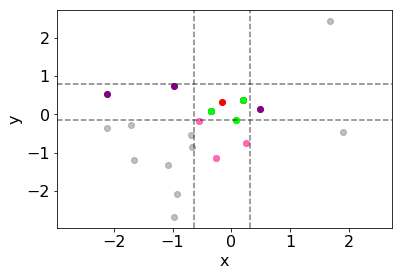

In [7]:
x, y = generate_data(n=20)
mi_eq8_data = mi_eq8(x, y, return_all=True)
plot_single_point(x, y, mi_eq8_data, 4)

## Eq. (9)

Not sure why cannot reproduce the result in the paper.

In [8]:
def mi_eq9(x, y, k=3, return_all=False):
    """
    Eq. (9) of arXiv:cond-mat/0305641
    
    Not sure why cannot reproduce the result in the paper.
    """
    n = x.size
    
    x = x[:, None]
    y = y[:, None]
    xy = np.hstack([x, y])
    
    # The metric used int he paper is Chebyshev
    nn = NearestNeighbors(metric='chebyshev', n_neighbors=k)
    
    # For every point, get the distance to the n nearest neighbors
    # epsilon(i)
    nn.fit(xy)
    dist, ind = nn.kneighbors()
    
    # Calculate epsilon_x(i) and epsilon_y(i)
    x_dist = np.array([chebyshev(a, b) for a, b in zip(x, x[ind[:, -1]])])
    y_dist = np.array([chebyshev(a, b) for a, b in zip(y, y[ind[:, -1]])])
    
    # For every point in x, get the number of neighbors < epsilon(i)
    nn.fit(x)
    x_ind = nn.radius_neighbors(radius=x_dist, return_distance=False)
    nx = np.array([i.size for i in x_ind])
    
    # For every point in y, get the number of neighbors < epsilon(i)
    nn.fit(y)
    y_ind = nn.radius_neighbors(radius=y_dist, return_distance=False)
    ny = np.array([i.size for i in y_ind])
    
    # Calcualte MI according to Eq. (8)
    mi = (digamma(k) - 1 / k
          - np.mean(digamma(nx)) - np.mean(digamma(ny))
          + digamma(n))
    
    if return_all:
        return {'mi': max(0, mi),
                'x_dist': x_dist, 'y_dist': y_dist, 'dist': dist, 
                'x_ind': x_ind, 'y_ind': y_ind, 'ind': ind}
    else:
        return max(0, mi)

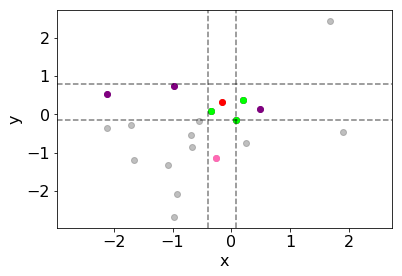

In [9]:
x, y = generate_data(n=20)
mi_eq9_data = mi_eq9(x, y, return_all=True)
plot_single_point(x, y, mi_eq9_data, 4)

## Calculation for Various r

In [10]:
n = 10000
k = 3
mi_r = pd.DataFrame([compare_mi_calc(r=r, n=n, k=k) for r in np.linspace(0, 0.99, 100)])

In [11]:
mi_r.head()

,eq8,eq9,exact,n,r,sklearn
0,0.007008,0.659043,0.019256,10000,0.00,0.006841
1,0.007666,0.678099,0.019306,10000,0.01,0.007708
2,0.007533,0.677577,0.019456,10000,0.02,0.007551
3,0.008109,0.676614,0.019706,10000,0.03,0.008153
4,0.009016,0.679278,0.020057,10000,0.04,0.009111


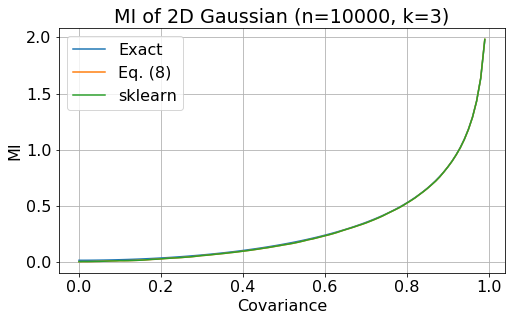

In [12]:
fig = plt.figure(figsize=[16/2, 9/2])
ax = fig.add_subplot(111)
ax.plot(mi_r['r'], mi_r['exact'], label='Exact')
ax.plot(mi_r['r'], mi_r['eq8'], label='Eq. (8)')
ax.plot(mi_r['r'], mi_r['sklearn'], label='sklearn')
ax.set_title('MI of 2D Gaussian (n={n}, k={k})'.format(n=n, k=k))
ax.set_xlabel('Covariance')
ax.set_ylabel('MI')
ax.grid()
plt.legend()
plt.savefig('plots/mi_v_r-eq8.png', bbox_inches='tight')
plt.show()

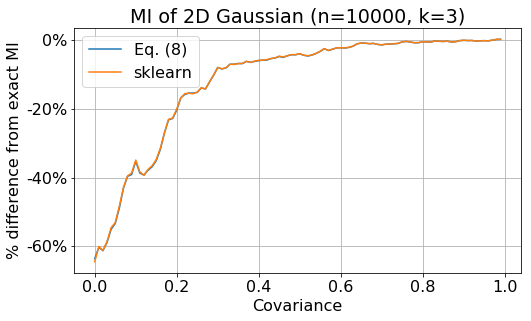

In [13]:
fig = plt.figure(figsize=[16/2, 9/2])
ax = fig.add_subplot(111)
ax.plot(mi_r['r'], (mi_r['eq8'] - mi_r['exact']) / mi_r['exact'], label='Eq. (8)')
ax.plot(mi_r['r'], (mi_r['sklearn'] - mi_r['exact']) / mi_r['exact'], label='sklearn')
yticks = ax.get_yticks()
ax.set_yticklabels(['{:.0f}%'.format(y*100) for y in yticks])
ax.set_title('MI of 2D Gaussian (n={n}, k={k})'.format(n=n, k=k))
ax.set_xlabel('Covariance')
ax.set_ylabel('% difference from exact MI')
ax.grid()
plt.legend()
plt.savefig('plots/mi_v_r-eq8-perct_diff.png', bbox_inches='tight')
plt.show()

## Calculation for Various n

In [14]:
r = 0.9
k = 1
mi_n = pd.DataFrame([compare_mi_calc(r=r, n=int(n), k=k) for n in np.linspace(100, 20000, 20)])

In [15]:
mi_n.head()

,eq8,eq9,exact,n,r,sklearn
0,0.936902,0.922721,0.783192,100,0.9,0.940477
1,0.839006,0.839345,0.873580,1147,0.9,0.838297
2,0.934465,0.910606,0.861864,2194,0.9,0.934386
3,0.900436,0.879766,0.851581,3242,0.9,0.900421
4,0.875546,0.852642,0.860258,4289,0.9,0.875407


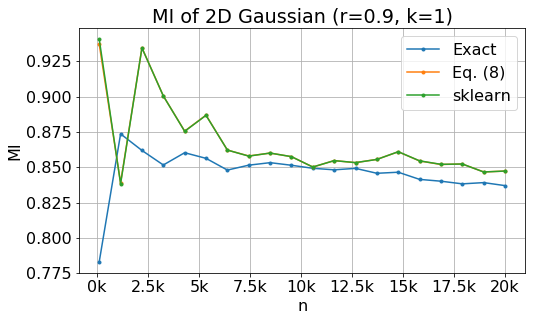

In [16]:
fig = plt.figure(figsize=[16/2, 9/2])
ax = fig.add_subplot(111)
ax.plot(mi_n['n'], mi_n['exact'], '.-', label='Exact')
ax.plot(mi_n['n'], mi_n['eq8'], '.-', label='Eq. (8)')
ax.plot(mi_n['n'], mi_n['sklearn'], '.-', label='sklearn')
xticks = ax.get_xticks()
ax.set_xticklabels([('{:.0f}k' if x/1e3 == int(x/1e3) else '{:.1f}k').format(x/1e3) for x in xticks])
ax.set_title('MI of 2D Gaussian (r={r}, k={k})'.format(r=r, k=k))
ax.set_xlabel('n')
ax.set_ylabel('MI')
ax.grid()
plt.legend()
plt.show()

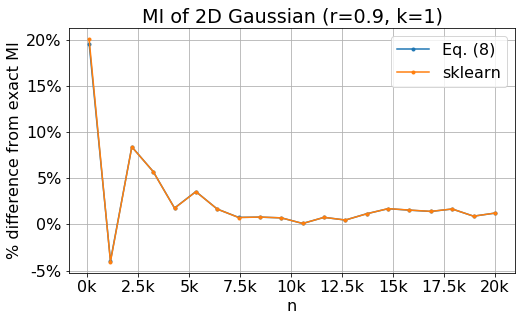

In [17]:
fig = plt.figure(figsize=[16/2, 9/2])
ax = fig.add_subplot(111)
ax.plot(mi_n['n'], (mi_n['eq8'] - mi_n['exact']) / mi_n['exact'], '.-', label='Eq. (8)')
ax.plot(mi_n['n'], (mi_n['sklearn'] - mi_n['exact']) / mi_n['exact'], '.-', label='sklearn')
xticks = ax.get_xticks()
ax.set_xticklabels([('{:.0f}k' if x/1e3 == int(x/1e3) else '{:.1f}k').format(x/1e3) for x in xticks])
yticks = ax.get_yticks()
ax.set_yticklabels(['{:.0f}%'.format(y*100) for y in yticks])
ax.set_title('MI of 2D Gaussian (r={r}, k={k})'.format(r=r, k=k))
ax.set_xlabel('n')
ax.set_ylabel('% difference from exact MI')
ax.grid()
plt.legend()
plt.savefig('plots/mi_v_n-eq8-perct_diff.png', bbox_inches='tight')
plt.show()

## Step by Step Eq. (8)

In [18]:
data = mi_eq8_data
i = 4

In [19]:
def setup_fig():
    fig = plt.figure(figsize=[16/2, 9/2])
    ax = fig.add_subplot(111)
    return ax
def poof(ax, path=None):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lim = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
    ax.set_title('MI Calculation (First Formulation)')
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if path:
        plt.savefig(path)
    plt.show()

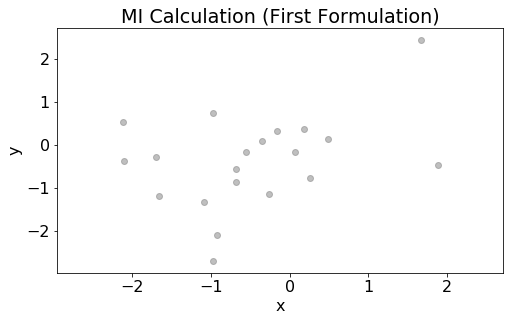

In [20]:
ax = setup_fig()
ax.scatter(x, y, c='gray', alpha=0.5)
poof(ax, 'plots/eq8-1.png')

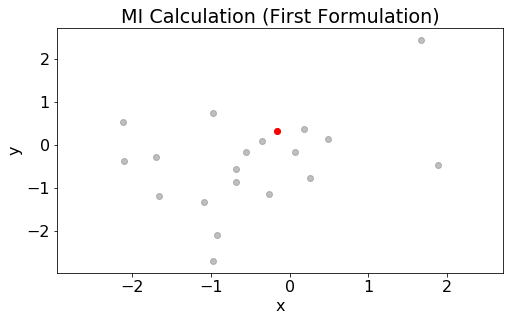

In [21]:
ax = setup_fig()
ax.scatter(x, y, c='gray', alpha=0.5)
ax.scatter(x[i], y[i], c='r')
poof(ax, 'plots/eq8-2.png')

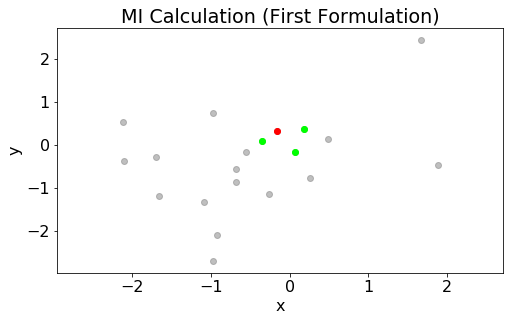

In [22]:
ax = setup_fig()
ax.scatter(x, y, c='gray', alpha=0.5)
ax.scatter(x[i], y[i], c='r')
for neighbor_i in data['ind'][i]:
    ax.scatter(x[neighbor_i], y[neighbor_i], c='lime')
poof(ax, 'plots/eq8-3.png')

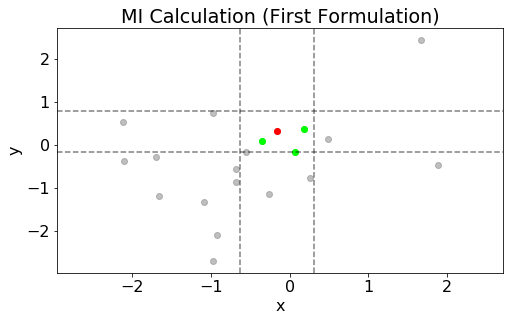

In [23]:
ax = setup_fig()
ax.axvline(x[i] + data['x_dist'][i], c='k', ls='--', alpha=0.5)
ax.axvline(x[i] - data['x_dist'][i], c='k', ls='--', alpha=0.5)
ax.axhline(y[i] + data['y_dist'][i], c='k', ls='--', alpha=0.5)
ax.axhline(y[i] - data['y_dist'][i], c='k', ls='--', alpha=0.5)
ax.scatter(x, y, c='gray', alpha=0.5)
ax.scatter(x[i], y[i], c='r')
for neighbor_i in data['ind'][i]:
    ax.scatter(x[neighbor_i], y[neighbor_i], c='lime')
poof(ax, 'plots/eq8-4.png')

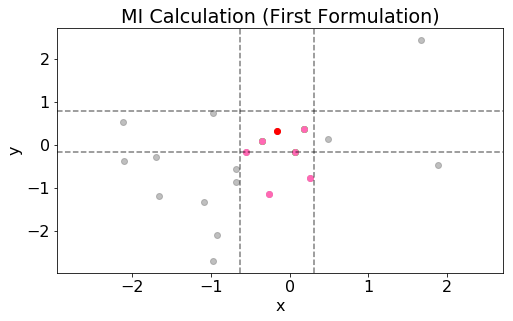

In [24]:
ax = setup_fig()
ax.axvline(x[i] + data['x_dist'][i], c='k', ls='--', alpha=0.5)
ax.axvline(x[i] - data['x_dist'][i], c='k', ls='--', alpha=0.5)
ax.axhline(y[i] + data['y_dist'][i], c='k', ls='--', alpha=0.5)
ax.axhline(y[i] - data['y_dist'][i], c='k', ls='--', alpha=0.5)
ax.scatter(x, y, c='gray', alpha=0.5)
ax.scatter(x[i], y[i], c='r')
for neighbor_i in data['ind'][i]:
    ax.scatter(x[neighbor_i], y[neighbor_i], c='lime')
for neighbor_i in data['x_ind'][i]:
    ax.scatter(x[neighbor_i], y[neighbor_i], c='hotpink')
poof(ax, 'plots/eq8-5.png')

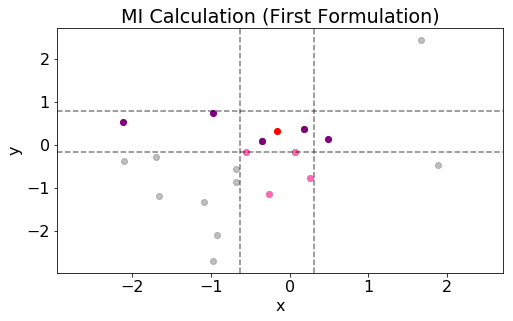

In [25]:
ax = setup_fig()
ax.axvline(x[i] + data['x_dist'][i], c='k', ls='--', alpha=0.5)
ax.axvline(x[i] - data['x_dist'][i], c='k', ls='--', alpha=0.5)
ax.axhline(y[i] + data['y_dist'][i], c='k', ls='--', alpha=0.5)
ax.axhline(y[i] - data['y_dist'][i], c='k', ls='--', alpha=0.5)
ax.scatter(x, y, c='gray', alpha=0.5)
ax.scatter(x[i], y[i], c='r')
for neighbor_i in data['ind'][i]:
    ax.scatter(x[neighbor_i], y[neighbor_i], c='lime')
for neighbor_i in data['x_ind'][i]:
    ax.scatter(x[neighbor_i], y[neighbor_i], c='hotpink')
for neighbor_i in data['y_ind'][i]:
    ax.scatter(x[neighbor_i], y[neighbor_i], c='purple')
poof(ax, 'plots/eq8-6.png')

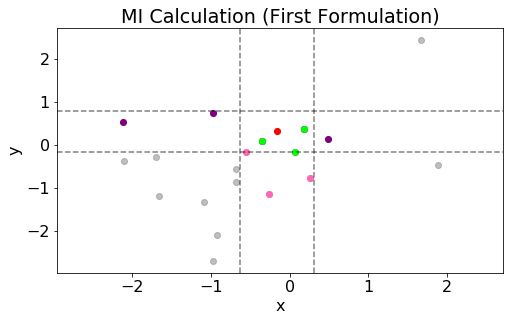

In [26]:
ax = setup_fig()
ax.axvline(x[i] + data['x_dist'][i], c='k', ls='--', alpha=0.5)
ax.axvline(x[i] - data['x_dist'][i], c='k', ls='--', alpha=0.5)
ax.axhline(y[i] + data['y_dist'][i], c='k', ls='--', alpha=0.5)
ax.axhline(y[i] - data['y_dist'][i], c='k', ls='--', alpha=0.5)
ax.scatter(x, y, c='gray', alpha=0.5)
for neighbor_i in data['x_ind'][i]:
    ax.scatter(x[neighbor_i], y[neighbor_i], c='hotpink')
for neighbor_i in data['y_ind'][i]:
    ax.scatter(x[neighbor_i], y[neighbor_i], c='purple')
ax.scatter(x[i], y[i], c='r')
for neighbor_i in data['ind'][i]:
    ax.scatter(x[neighbor_i], y[neighbor_i], c='lime')
poof(ax, 'plots/eq8-7.png')